In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
#Fit Gauss to a Gaussian
def gaus(x,a,sig):
    return a*np.exp(-(x)**2/(2.*sig**2))

In [3]:
# Returns the fractional window function uncertainty as a function of
# ell=np.linspace(0,50000,50001)
def get_tc_uncertainty(fwhm,f3db):
    #parameters
    el= 45. #scan elevation in degrees
    fscan= 1.#scan speed of the telescope deg/s
    fsky=fscan*np.cos(el*np.pi/180.) #deg/s on sky scan speed
    #frequency space Gaussian beam
    sigma=fwhm/(60.*2.*fsky*np.sqrt(2.*np.log(2)))
    t_range=100000.
    t_points=10000000
    t_freq=np.linspace(-t_range,t_range,t_points)
    sample_rate=(t_points/(2.*t_range))
    gauss_2=np.exp(-2.*np.pi**2*t_freq**2*sigma**2)

    pshift=np.zeros(len(f3db))
    FWHM_new=np.zeros(len(f3db))
    for ii in range(len(f3db)):

            #Make Lowpass Filter (and apply to negative side--this is just the scan direction)
            h=(1.-1j*(-t_freq/f3db[ii]))/(1.+np.square(-t_freq/f3db[ii]))
            filtered_2=np.copy(gauss_2)*h
            filtered=np.copy(filtered_2)

            #Take FFT of Convoluted Beam
            gffted=np.abs(np.fft.fft(gauss_2))
            ffted=np.fft.fft(filtered)
            rffted=np.absolute(ffted)
            #make position array of the same length
            pos1=np.linspace(0,len(rffted)-1,len(rffted))
            #normalize to one and scale by sample rate and convert into degrees
            pos2=(pos1/len(rffted))*sample_rate*fsky

            #put the plot back together
            #First section of fft
            fftr1=rffted[0:len(rffted)/2]
            #print pointing offset
            pshift[ii]=pos2[np.argmax(fftr1)]*60.
            #print f3db[ii], 'Hz', pshift[ii], 'arcmin'
            #Find x value where value is half
            x=np.copy(pos2[0:len(pos2)/2])
            yf=np.copy(fftr1)
            y=yf/np.max(yf)
            xp=np.fliplr([x])[0]
            yp=np.fliplr([y])[0]
            half=np.interp([0.5],yp,xp)
            FWHM_new[ii]=(half[0]*60.-pshift[ii])*2.
            #print "Beam FWHM: ",FWHM_new[ii], "arcmin"
            #print "Change in FWHM: ",FWHM_new[ii]-fwhm, "arcmin"
            
    # calculate error in pointing from time constant uncertainty
    p_10=pshift[1]-pshift[0]
    #print "Pointing error: ", p_10*60., "arcsec"
    print "Pointing error: ", p_10*60., "arcsec"
    #Take units in arcminutes
    fwhm_shift=np.zeros(len(f3db))
    for jj in range(len(f3db)):
      #print '%0.2f Hz:'%f3db[jj]
      angle=np.linspace(-500,500,100000)
      poff=pshift[jj]
      sigma2=FWHM_new[jj]/(2.*np.sqrt(2.*np.log(2)))
      a=1./(sigma2*np.sqrt(2*np.pi))
      top1=-0.5*((angle-poff)**2/sigma2**2)
      top2=-0.5*((angle+poff)**2/sigma2**2)
      #These are the two gaussians
      gauss_a=a*np.exp(top1)
      gauss_b=a*np.exp(top2)

      #Make the combined beam
      gauss=gauss_a+gauss_b

      #Find FWHM and thus the best guess of sigma (assume centered around zero)
      aa=np.copy(angle)
      yyf=np.copy(gauss)
      yy=yyf/np.max(yyf)
      half=np.interp([0.5],yy[0:len(angle)/2],aa[0:len(angle)/2])
      fwhm_fit=np.absolute(2*half[0])
      #print 'Guess: ',fwhm_fit
      sigfit=fwhm_fit/(2.*np.sqrt(2.*np.log(2)))

      popt,pcov = curve_fit(gaus,angle,gauss,p0=[1,sigfit])
      fwhm_shift[jj]=popt[1]*(2.*np.sqrt(2.*np.log(2)))
      #print 'FWHM Fit: ',fwhm_shift[jj], "arcmin"
      #print 'Change in FWHM: ',popt[1]*(2.*np.sqrt(2.*np.log(2)))-fwhm
      #take these and look at their Gaussian window functions
    l=np.linspace(0,50000,50001)
    sigma_nt=(fwhm/60.)*(np.pi/180.)/np.sqrt(8*np.log(2))
    #Gaussian window function, no time constant
    bl=np.exp(-l*(l+1)*sigma_nt**2)
    #with base time constant
    sigma_tc=(fwhm_shift[0]/60.)*(np.pi/180.)/np.sqrt(8*np.log(2))
    blm_orig=np.exp(-l*(l+1)*sigma_tc**2)
    #base time constant + err
    sigma_mod=(fwhm_shift[1]/60.)*(np.pi/180.)/np.sqrt(8*np.log(2))
    blm=np.exp(-l*(l+1)*sigma_mod**2)
    #pct_diff
    pct_diff_tc=(blm_orig-blm_orig)/bl
    pct_diff=(blm-blm_orig)/bl
    return pct_diff

In [4]:
#case 1-baseline, freq=90 GHz
print "Case 1, 90 GHz:"
fwhm=2.1 #beam FWHM in arcmin
f3db_b=144.
f3db=[f3db_b,(f3db_b-0.3*f3db_b)] #30% uncertainty
pct_diff_r1=get_tc_uncertainty(fwhm,f3db)
print "fractional difference at ell=5000: ", pct_diff_r1[5001]

Case 1, 90 GHz:
Pointing error:  1.1964246737676378 arcsec
fractional difference at ell=5000 -0.009494224055791966


In [5]:
#case 2-half, freq=90 GHz
print "Case 2, 90 GHz:"
fwhm=2.1 #beam FWHM in arcmin
f3db_b=210.
f3db=[f3db_b,(f3db_b-0.3*f3db_b)] #30% uncertainty
pct_diff_r2=get_tc_uncertainty(fwhm,f3db)
print "fractional difference at ell=5000: ", pct_diff_r2[5001]

Case 2, 90 GHz:
Pointing error:  0.8273149339882611 arcsec
fractional difference at ell=5000 -0.004340536249334581


In [6]:
#case 3-fourth, freq=90 GHz
print "Case 3, 90 GHz:"
fwhm=2.1 #beam FWHM in arcmin
f3db_b=258.
f3db=[f3db_b,(f3db_b-0.25*f3db_b)] #25% uncertainty
pct_diff_r3=get_tc_uncertainty(fwhm,f3db)
print "fractional difference at ell=5000: ", pct_diff_r3[5001]

Case 3, 90 GHz:
Pointing error:  0.5218448045156716 arcsec
fractional difference at ell=5000 -0.0022662893072153615


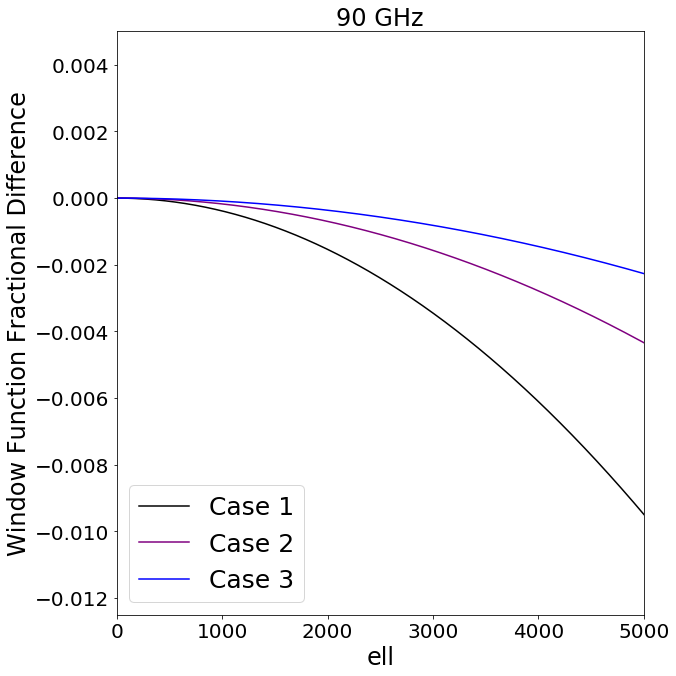

In [13]:
ell=np.linspace(0,50000,50001)
fig,ax=plt.subplots(figsize=(9.5,9.5))
plt.plot(ell,pct_diff_r1, color='k', label="Case 1")
plt.plot(ell,pct_diff_r2, color='purple', label="Case 2")
plt.plot(ell,pct_diff_r3, color='blue', label="Case 3")
ax.set_xlim(0,5000)
ax.set_ylim(-0.0125,0.005)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(20)
ax.set_xlabel('ell',fontsize=24)
ax.set_ylabel('Window Function Fractional Difference',fontsize=24)
ax.set_title('90 GHz',fontsize=24)
ax.legend(loc=3,prop={'size': 25})
fig.tight_layout()
plt.show()

In [8]:
#case 1-baseline, freq=150 GHz
print "Case 1, 150 GHz:"
fwhm=1.3 #beam FWHM in arcmin
f3db_b=165.8
f3db=[f3db_b,(f3db_b-0.3*f3db_b)] #30% uncertainty
pct_diff_r4=get_tc_uncertainty(fwhm,f3db)
print "fractional difference at ell=5000: ", pct_diff_r4[5001]

Case 1, 150 GHz:
Pointing error:  1.0182337649086286 arcsec
fractional difference at ell=5000 -0.007512635358353688


In [9]:
#case 2-half, freq=150 GHz
print "Case 2, 150 GHz:"
fwhm=1.3 #beam FWHM in arcmin
f3db_b=225.
f3db=[f3db_b,(f3db_b-0.3*f3db_b)] #30% uncertainty
pct_diff_r5=get_tc_uncertainty(fwhm,f3db)
print "fractional difference at ell=5000: ", pct_diff_r5[5001]

Case 2, 150 GHz:
Pointing error:  0.7636753236814715 arcsec
fractional difference at ell=5000 -0.003971648457097041


In [10]:
#case 3-fourth, freq=150 GHz
print "Case 3, 150 GHz:"
fwhm=1.3 #beam FWHM in arcmin
f3db_b=290.
f3db=[f3db_b,(f3db_b-0.25*f3db_b)] #25% uncertainty
pct_diff_r6=get_tc_uncertainty(fwhm,f3db)
print "fractional difference at ell=5000: ", pct_diff_r6[5001]

Case 3, 150 GHz:
Pointing error:  0.4582051942088828 arcsec
fractional difference at ell=5000 -0.0019438728314685651


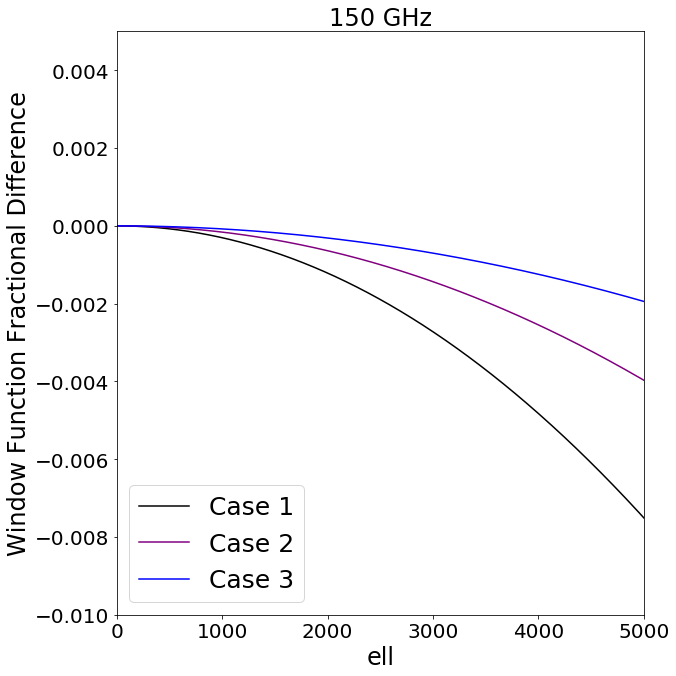

In [14]:
ell=np.linspace(0,50000,50001)
fig,ax=plt.subplots(figsize=(9.5,9.5))
plt.plot(ell,pct_diff_r4, color='k', label="Case 1")
plt.plot(ell,pct_diff_r5, color='purple', label="Case 2")
plt.plot(ell,pct_diff_r6, color='blue', label="Case 3")
ax.set_xlim(0,5000)
ax.set_ylim(-0.01,0.005)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(20)
ax.set_xlabel('ell',fontsize=24)
ax.set_ylabel('Window Function Fractional Difference',fontsize=24)
ax.set_title('150 GHz',fontsize=24)
ax.legend(loc=3,prop={'size': 25})
fig.tight_layout()
plt.show()